In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [18]:
df.set_index('date', inplace=True)
df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [19]:
# รวมจำนวนแก้วที่ขายแต่ละเมนู ในแต่ละวัน
daily_sales = (
    df.groupby(['date', 'coffee_name'])
      .size()
      .reset_index(name='cups_sold')
)
daily_sales.head()

,date,coffee_name,cups_sold
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


In [20]:
# DataFrame for the number of cups sold per day
daily_total_sales = df.groupby('date').size().reset_index(name='total_cups')
daily_total_sales.head()

,date,total_cups
0,2023-03-01,125
1,2023-03-02,125
2,2023-03-03,127
3,2023-03-04,64
4,2023-03-05,66


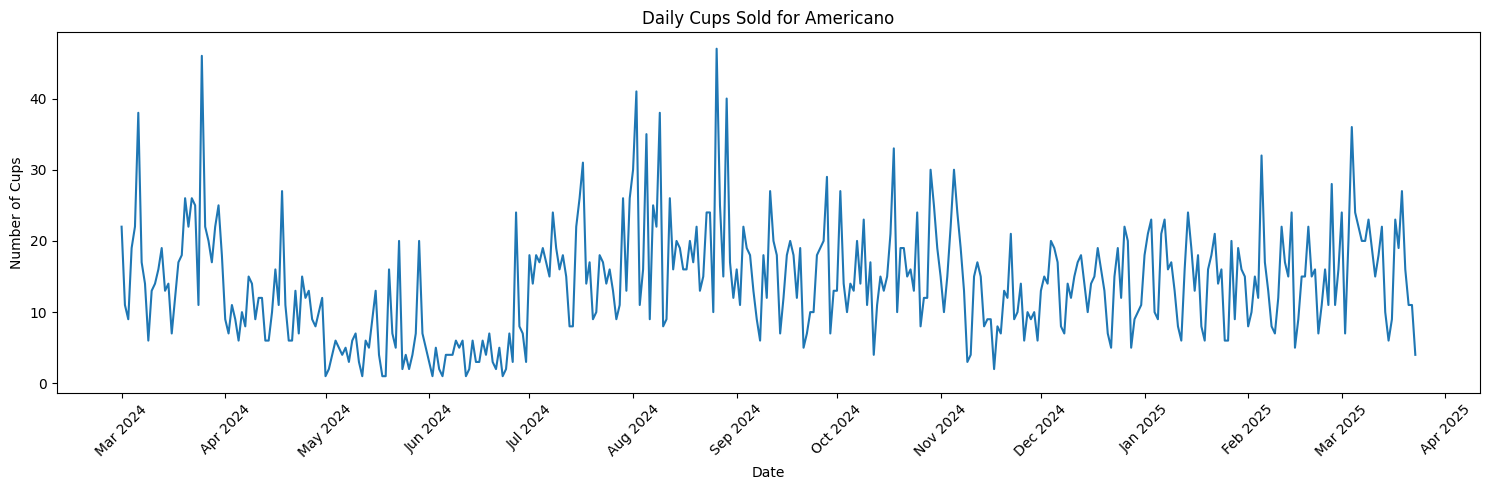

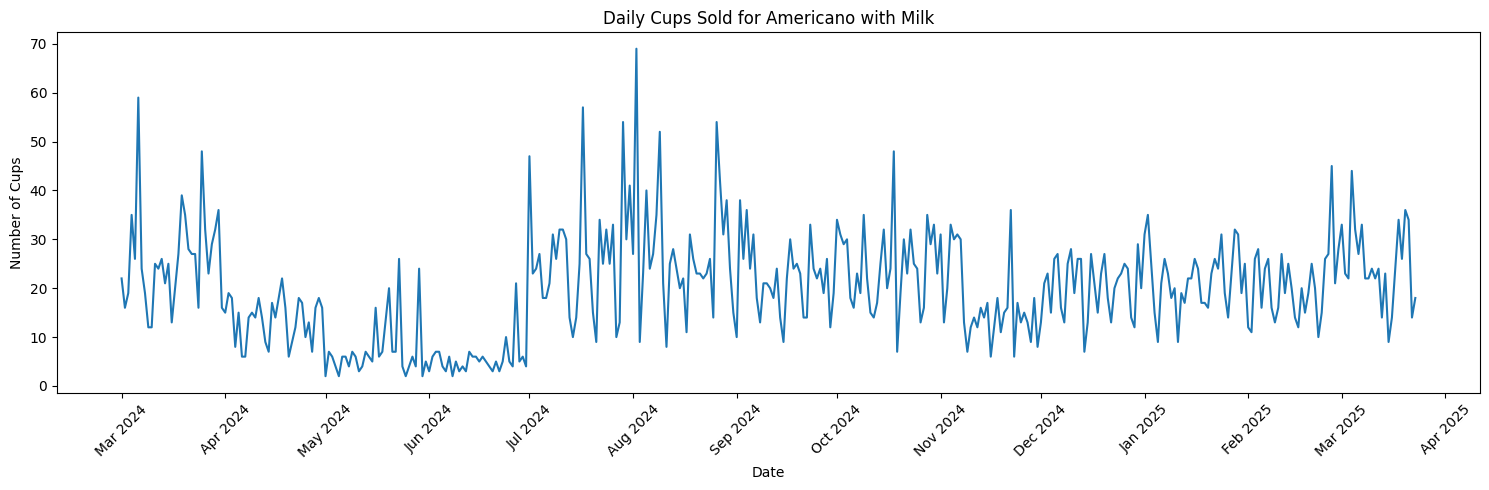

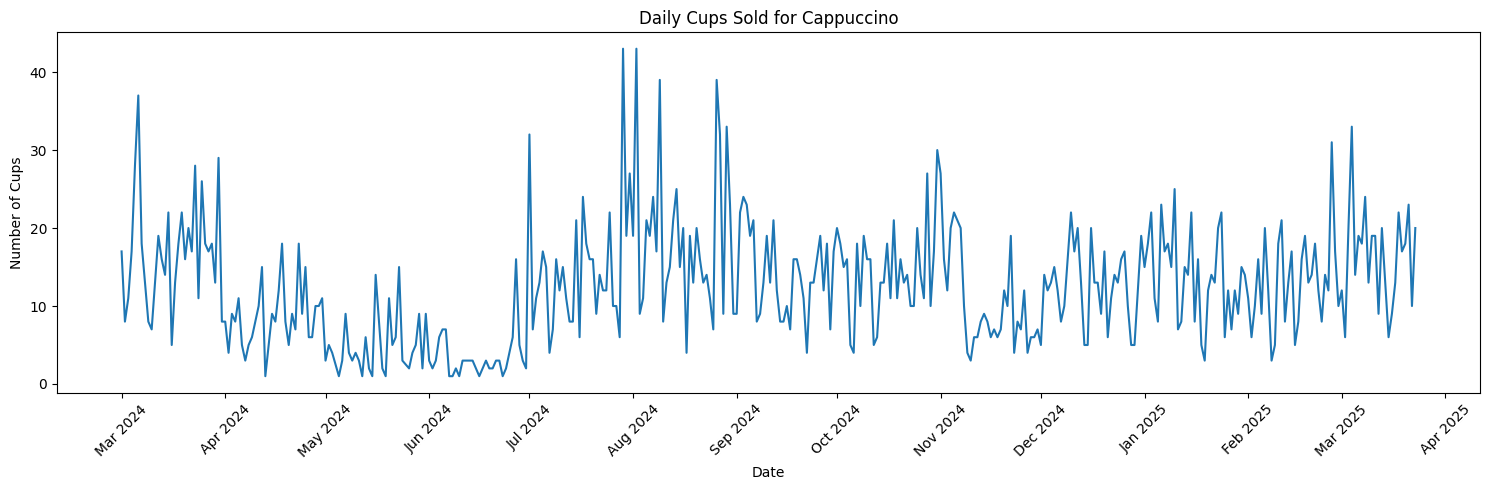

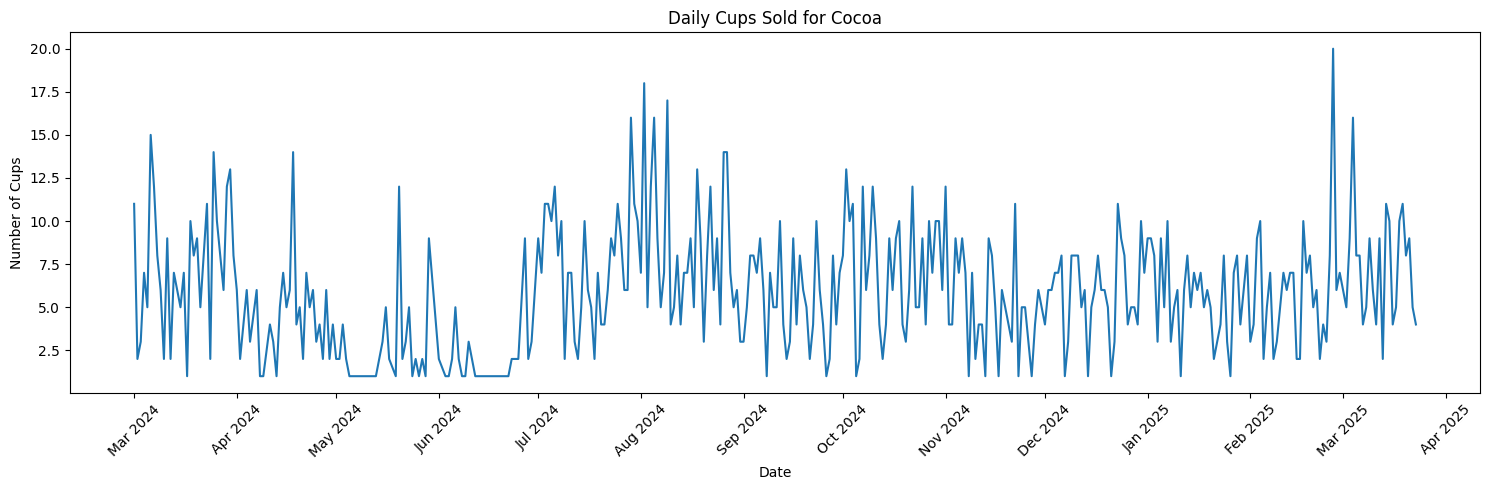

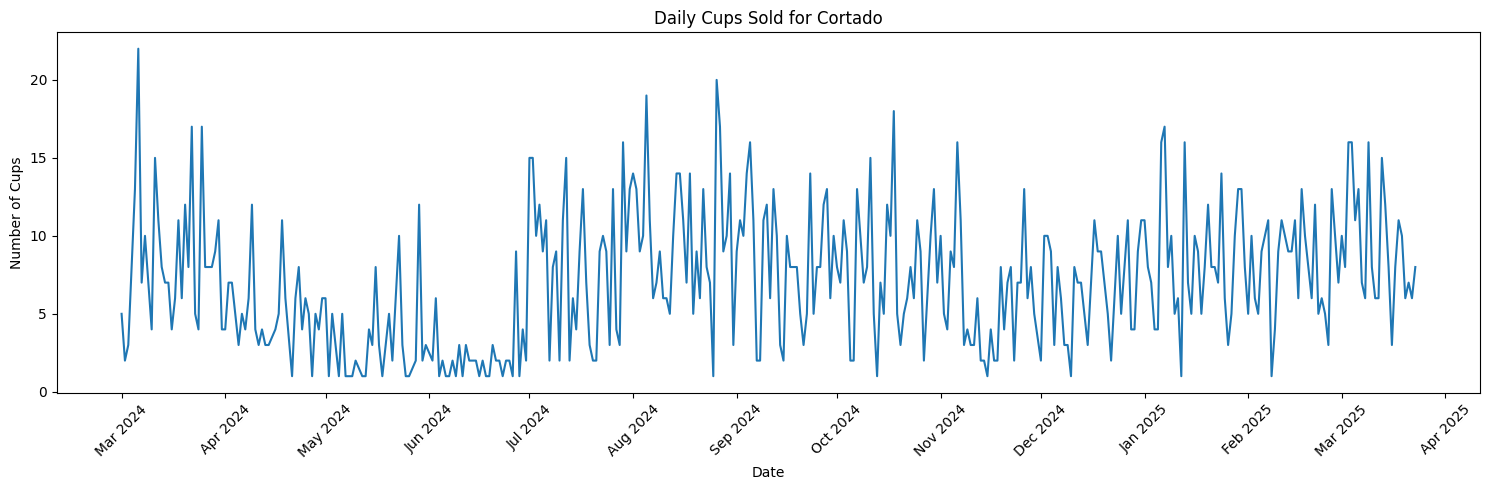

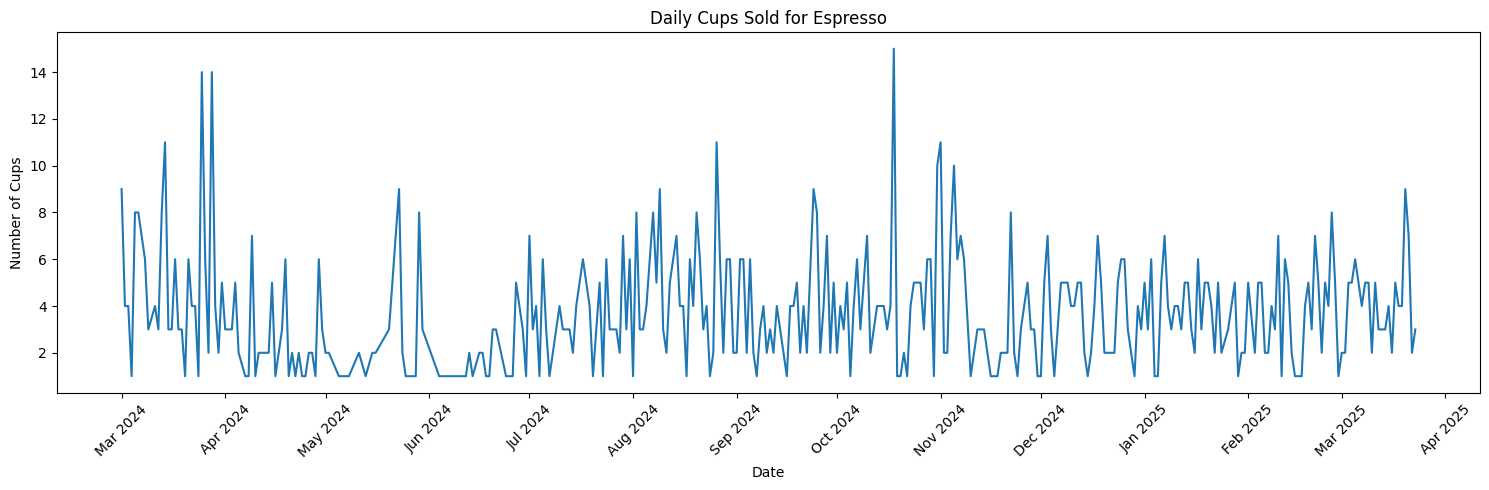

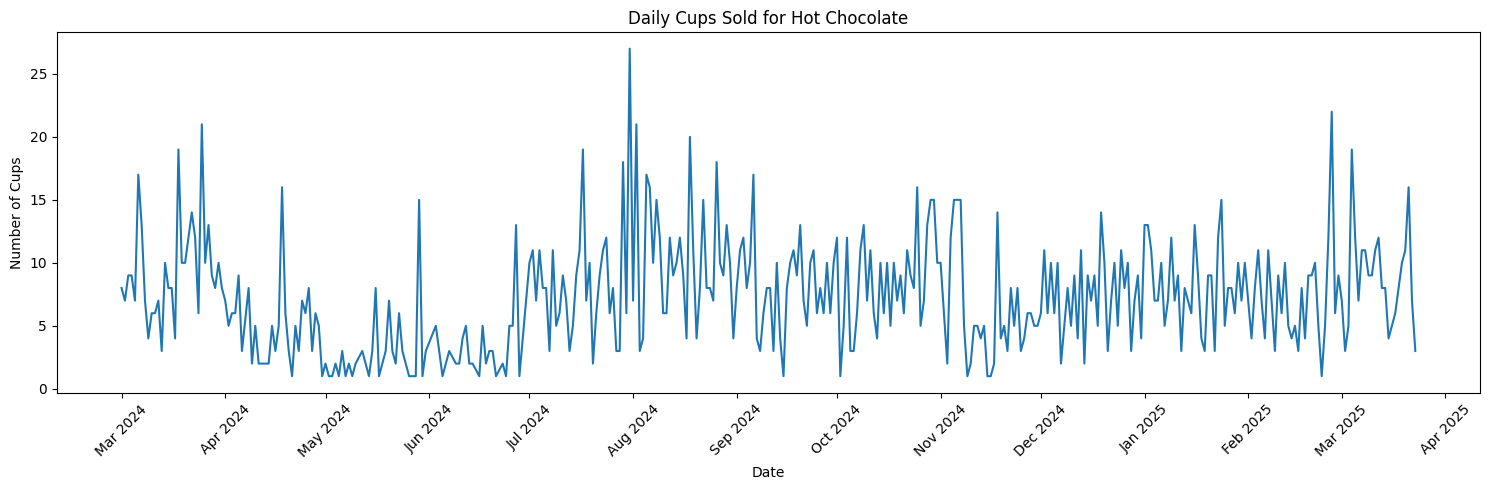

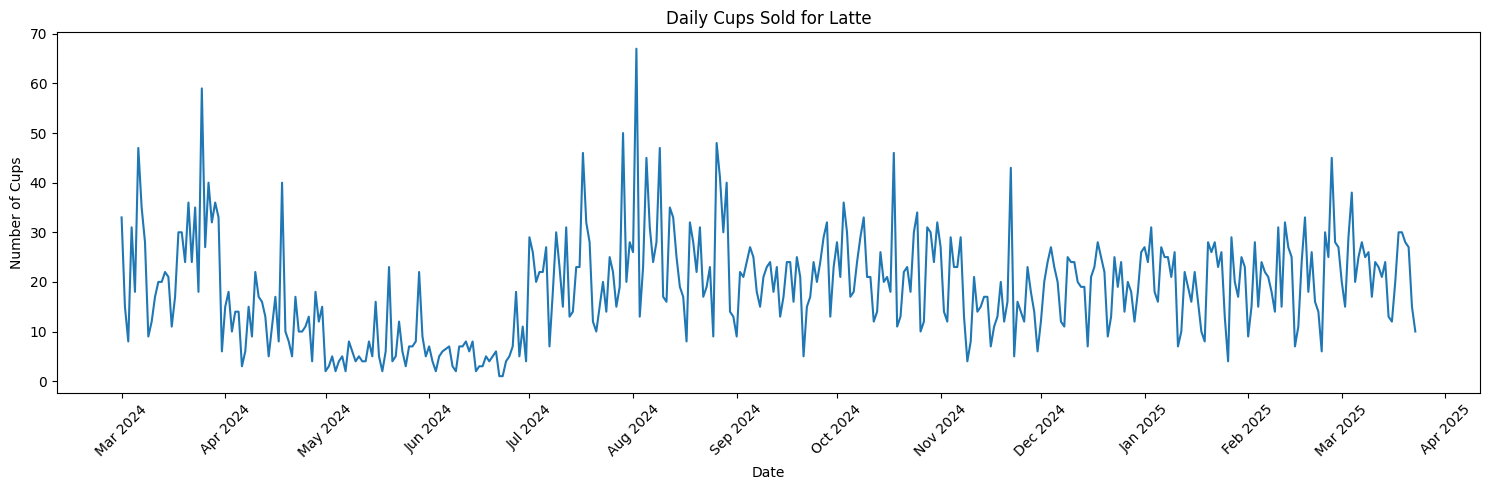

In [21]:
# DataFrame for the number of cups sold per coffee item per day
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')

# Plot daily cups sold for each coffee item
for coffee_name in daily_item_counts['coffee_name'].unique():
    coffee_sales = daily_item_counts[daily_item_counts['coffee_name'] == coffee_name].copy()

    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
        coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')
    coffee_sales.dropna(subset=['date'], inplace=True)

    # Filter by date range
    start_date = '2024-03-01'
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    # Set date as index
    coffee_sales.set_index('date', inplace=True)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['count'])
    plt.title(f'Daily Cups Sold for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Number of Cups')

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:
def create_cups_features(df):
    # Ensure date is datetime and set as index
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    df['lag_7'] = df['total_cups'].shift(7)
    df['lag_14'] = df['total_cups'].shift(14)

    # Create Rolling Mean (average of past 7 days, not including current day)
    df['rolling_mean_7'] = df['total_cups'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


# ใช้ฟังก์ชันกับ daily_total_sales (นับจำนวนแก้วต่อวัน)
daily_total_cups_features = create_cups_features(daily_total_sales.copy())

# ลบแถว NaN ที่เกิดจาก lag/rolling features
daily_total_cups_features.dropna(inplace=True)

# ดูตัวอย่าง
display(daily_total_cups_features.head())



,date,total_cups,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-15,106,2,1,3,74,2023,106.0,125.0,93.857143
15,2023-03-16,106,3,1,3,75,2023,105.0,125.0,93.857143
16,2023-03-17,108,4,1,3,76,2023,103.0,127.0,94.000000
17,2023-03-18,77,5,1,3,77,2023,81.0,64.0,94.714286
18,2023-03-19,70,6,1,3,78,2023,53.0,66.0,94.142857


In [24]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date': df.reset_index(inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [25]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_cups'

In [ ]:
X = daily_total_cups_features[FEATURES]
y = daily_total_cups_features[TARGET]

In [29]:
# กำหนด split date
split_date = '2025-03-01'
daily_total_cups_features['date'] = pd.to_datetime(daily_total_cups_features['date'])

# แบ่ง train/test
train_data = daily_total_cups_features[daily_total_cups_features['date'] < split_date]
test_data =daily_total_cups_features[daily_total_cups_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]

# แสดงขนาดชุดข้อมูลเหมือนอาจารย์
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (717, 7)
Shape of y_train: (717,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)


In [30]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [32]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [34]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [35]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} แก้ว จากทั้งหมด {len(y_test)} วัน")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} แก้ว จากทั้งหมด {len(y_test)} วัน")
print(f"จำนวนแก้วรวมใน Test Set: {y_test.sum():.0f} แก้ว")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 18.14 แก้ว จากทั้งหมด 61 วัน
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 15.86 แก้ว จากทั้งหมด 61 วัน
จำนวนแก้วรวมใน Test Set: 5407 แก้ว


In [36]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

results.index = test_data['date']

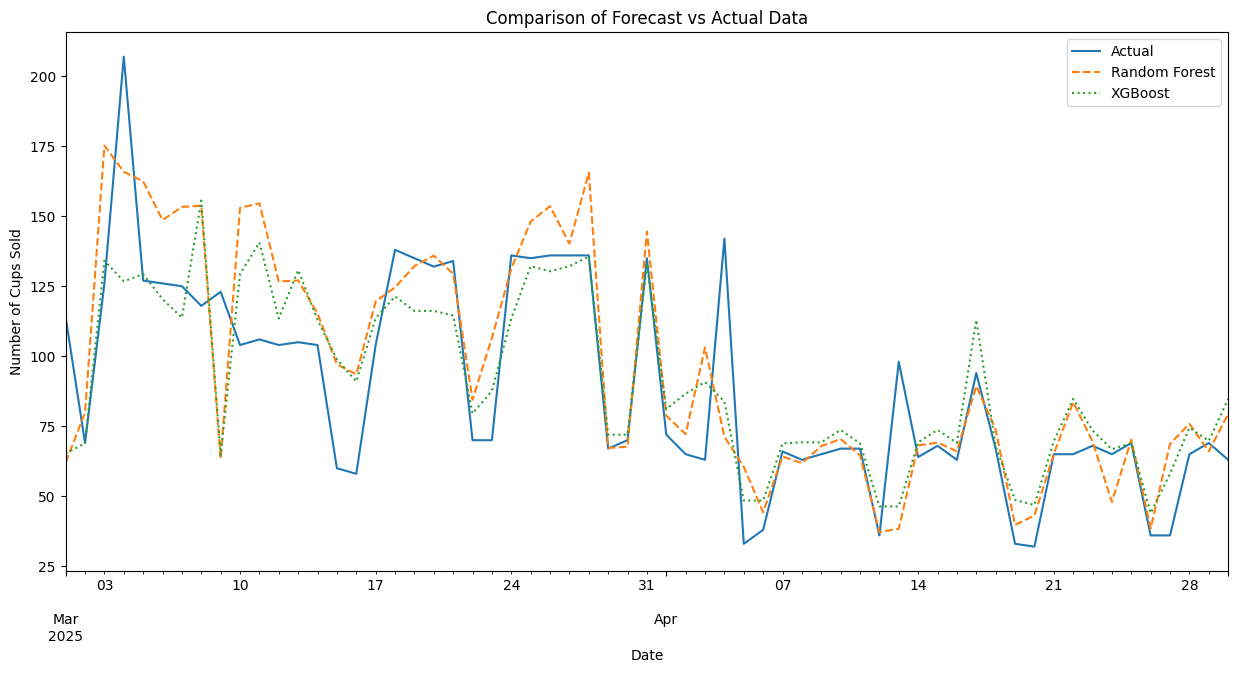

In [37]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Cups Sold')
plt.xlabel('Date')
plt.legend()
plt.show()


In [44]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    # plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model')
    plt.xticks(rotation=45)
    plt.xlabel('Features')
    plt.show()

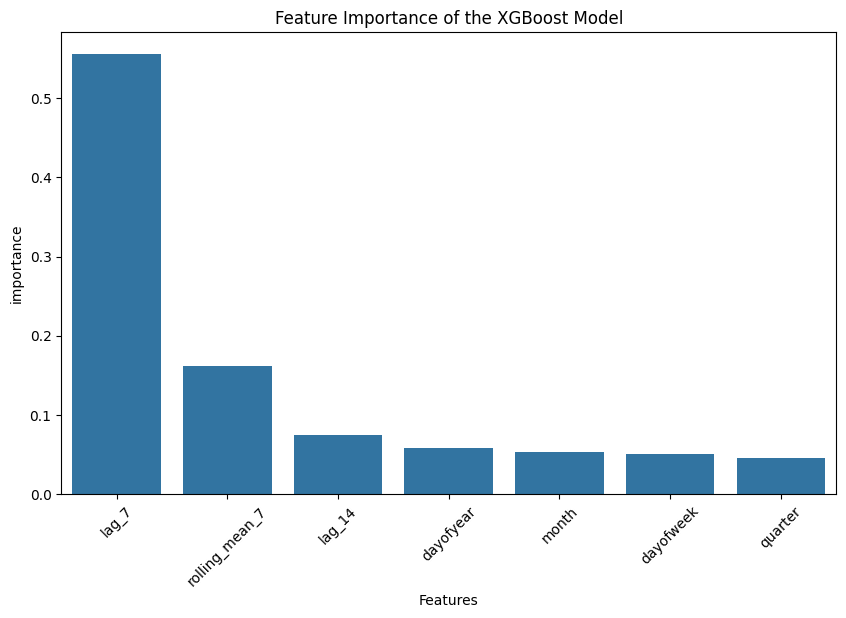

In [45]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

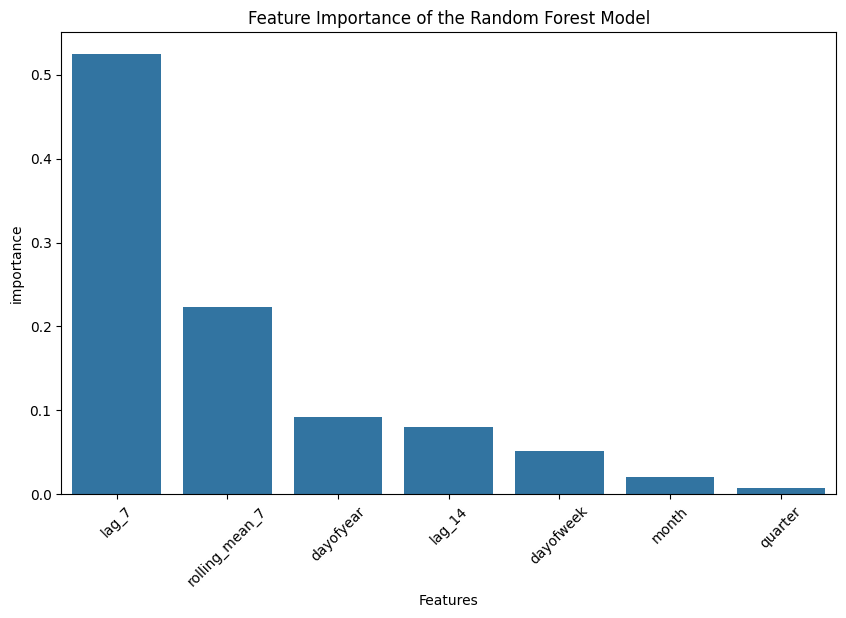

In [46]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [47]:
#ใช้  prophet

In [48]:
!pip install prophet

In [49]:
from prophet import Prophet

In [50]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'total_cups', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'total_cups', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [51]:
prophet_train = train_data[['date', TARGET]].rename(columns={'date': 'ds', TARGET: 'y'})
prophet_test  = test_data[['date', TARGET]].rename(columns={'date': 'ds', TARGET: 'y'})


In [52]:
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgtfsk7s/t4ic3k2v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgtfsk7s/l3r3yrod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51826', 'data', 'file=/tmp/tmpmgtfsk7s/t4ic3k2v.json', 'init=/tmp/tmpmgtfsk7s/l3r3yrod.json', 'output', 'file=/tmp/tmpmgtfsk7s/prophet_model0pdb0niv/prophet_model-20250921135037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:50:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [53]:
display(y_test.index)

Index([731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744,
       745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
       773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786,
       787, 788, 789, 790, 791],
      dtype='int64')

In [54]:
future = model.make_future_dataframe(periods=60)

In [55]:
forecast = model.predict(future)

In [56]:
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2023-03-15,135.825381,102.214170,170.719956
1,2023-03-16,135.772801,99.814516,169.977966
2,2023-03-17,130.838165,98.343728,164.379325
3,2023-03-18,87.682287,52.008548,122.280981
4,2023-03-19,88.687217,56.309455,123.490158


In [57]:
# Evaluate the Prophet model
# Merge actual values with forecast
prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
prophet_results.dropna(inplace=True) # Drop rows where there are no actual values (if future was longer than test)

In [58]:
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

print(f"ความคลาดเคลื่อนเฉลี่ยของ Prophet: {prophet_mae:.2f} แก้ว จากทั้งหมด {len(prophet_results)} วัน")
print(f"จำนวนแก้วรวมใน Test Set (สำหรับ Prophet): {prophet_results['y'].sum():.0f} แก้ว")

ความคลาดเคลื่อนเฉลี่ยของ Prophet: 17.91 แก้ว จากทั้งหมด 60 วัน
จำนวนแก้วรวมใน Test Set (สำหรับ Prophet): 5344 แก้ว


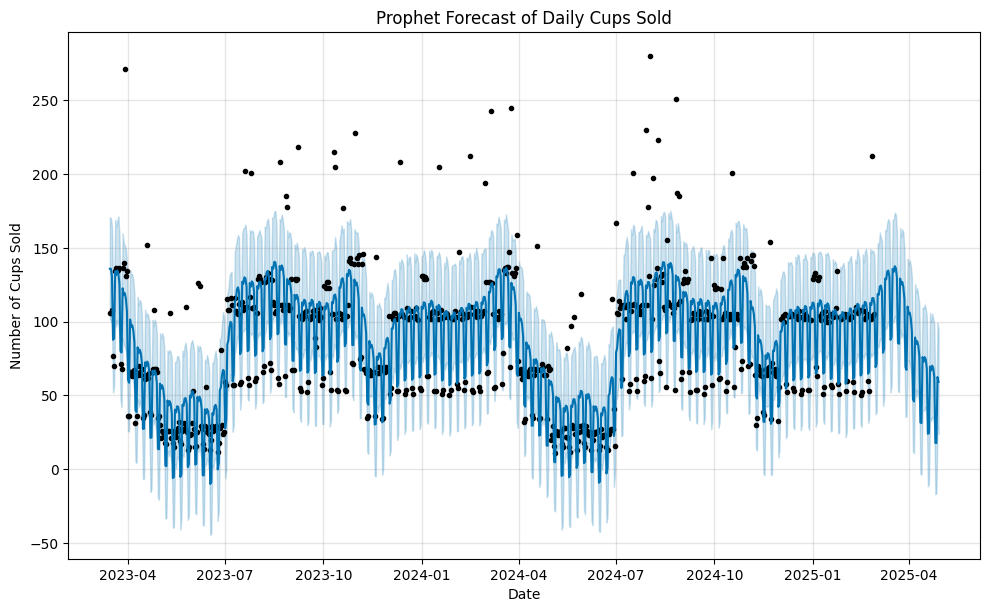

In [59]:
fig1 = model.plot(forecast)
plt.title('Prophet Forecast of Daily Cups Sold')
plt.xlabel('Date')
plt.ylabel('Number of Cups Sold')
plt.show()

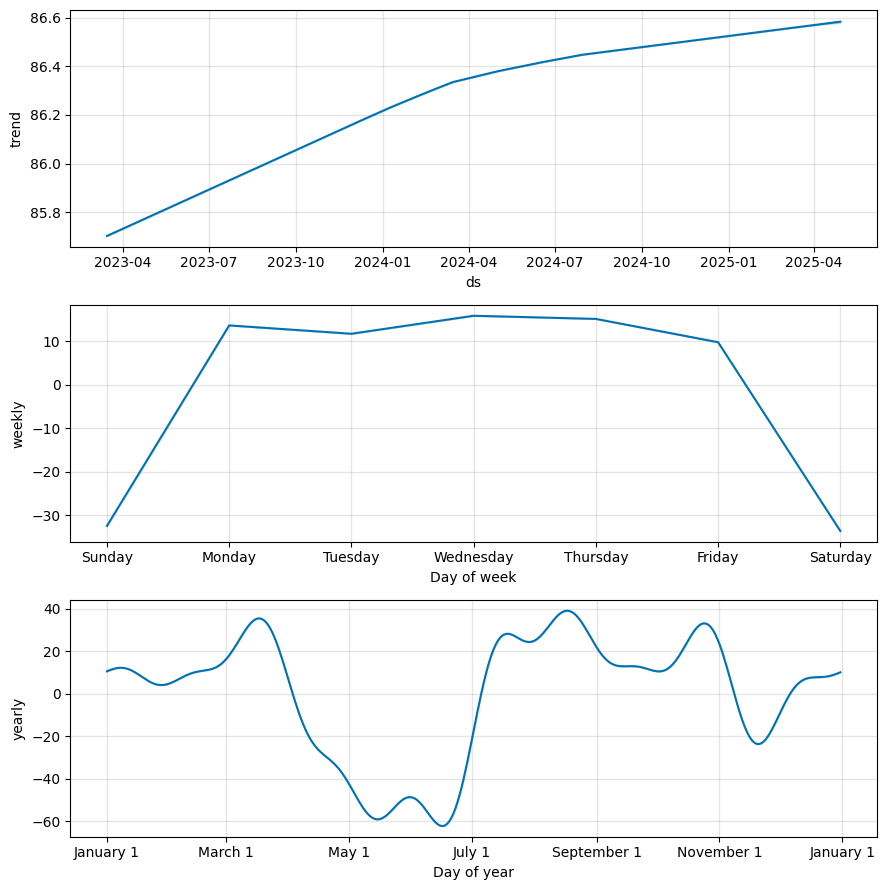

In [60]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

In [61]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-82lyl5lc
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-82lyl5lc
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-vxncr3zn/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [63]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [65]:
split_date = pd.to_datetime('2025-03-01')
historical_sales_before_split = daily_total_sales[daily_total_sales['date'] < split_date].copy()

context = torch.tensor(historical_sales_before_split['total_cups'].values)

prediction_length = 60

forecast = pipeline.predict(context, prediction_length)

median_prediction = forecast[0].median(dim=0).values

print(f"Chronos Median Forecast for the next {prediction_length} days (total_cups):")
display(median_prediction)

Chronos Median Forecast for the next 60 days (total_cups):


tensor([ 52.8403,  52.8403, 101.7665, 103.7236, 105.0283, 105.0283, 105.0283,
         54.7974,  54.1450, 101.7665, 103.7236, 103.7236, 103.7236, 103.7236,
         54.1450,  52.8403, 101.1142, 103.0712, 101.7665, 101.7665, 103.7236,
         52.8403,  52.8403, 101.1142, 103.0712, 101.7665, 103.0712, 103.0712,
         52.8403,  52.1880, 101.7665, 101.7665, 101.7665, 103.0712, 103.7236,
         52.8403,  52.1880, 101.1142, 101.7665, 101.7665, 103.0712, 101.7665,
         54.1450,  52.1880, 101.1142, 101.7665, 101.7665, 101.7665, 101.7665,
         52.8403,  52.8403, 101.7665, 103.0712, 101.7665, 103.0712, 101.7665,
         52.8403,  52.8403,  99.8095, 101.7665])

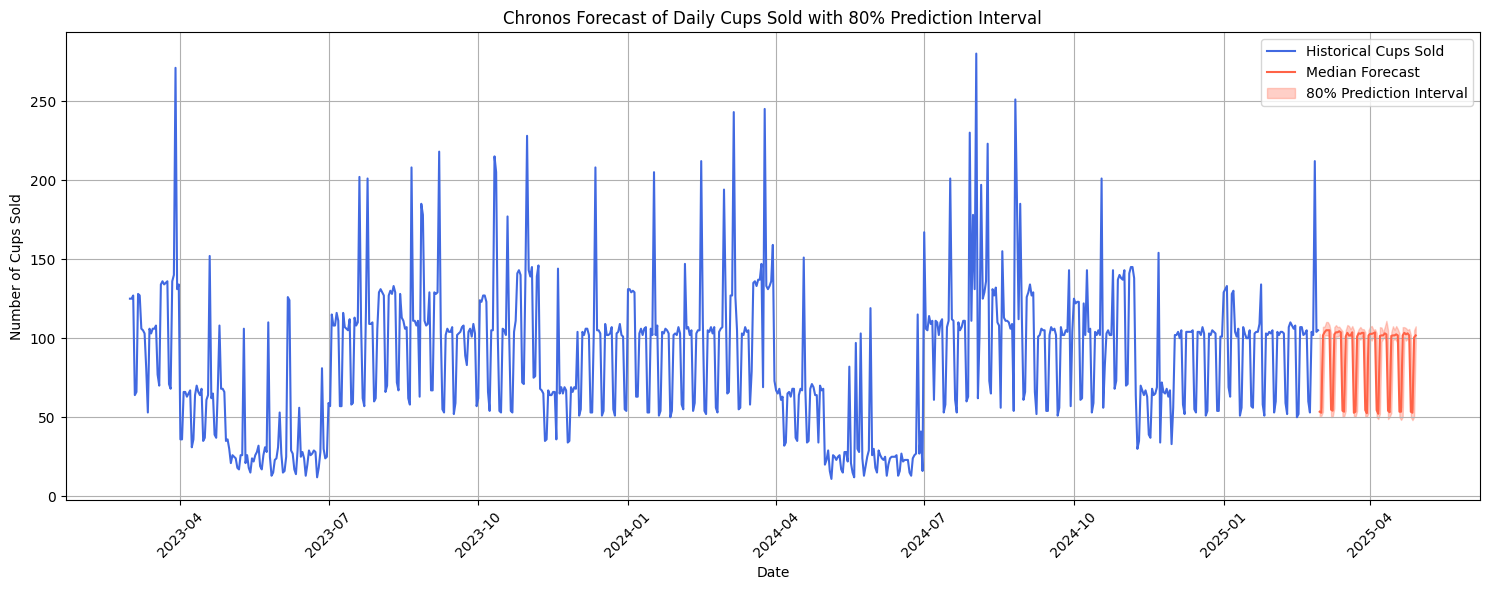

In [66]:
plt.figure(figsize=(15, 6))

plt.plot(historical_sales_before_split['date'], historical_sales_before_split['total_cups'], color="royalblue", label="Historical Cups Sold")

last_date_historical = historical_sales_before_split['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1), periods=prediction_length, freq='D')

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")

plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

plt.title('Chronos Forecast of Daily Cups Sold with 80% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Number of Cups Sold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
forecast[0][:][0]

tensor([ 52.1880,  54.1450, 105.0283, 101.7665, 105.0283, 105.0283, 101.7665,
         58.0591,  54.1450, 105.0283, 101.7665, 105.0283, 202.8807, 103.7236,
         52.1880,  58.0591, 103.7236,  96.5477, 101.1142, 101.1142, 103.0712,
         50.8833,  54.1450, 101.1142, 101.1142,  99.1571, 103.0712, 103.0712,
         52.1880,  54.1450, 103.0712,  97.2001, 202.8807, 101.7665, 101.1142,
         50.2309,  52.8403, 101.7665, 101.7665, 101.1142, 103.0712,  97.8524,
         48.2739,  56.1021, 103.0712, 103.0712,  99.8095, 103.0712, 101.7665,
         48.9262,  54.1450, 105.0283, 105.0283, 101.7665, 104.3759,  99.8095,
         50.8833,  54.1450, 105.0283, 103.0712])

In [68]:
median_forecast = np.median(forecast[0].numpy(), axis=0)

print(f"ค่ามัธยฐานของการพยากรณ์จำนวนแก้วที่ขายต่อวัน สำหรับ 60 วันข้างหน้า:")
display(median_forecast)

ค่ามัธยฐานของการพยากรณ์จำนวนแก้วที่ขายต่อวัน สำหรับ 60 วันข้างหน้า:


array([ 53.49266 ,  52.84031 , 101.76652 , 103.723564, 105.028275,
       105.028275, 105.028275,  54.797356,  54.145008, 102.41887 ,
       103.723564, 103.723564, 104.375916, 103.723564,  54.145008,
        53.49266 , 101.11417 , 103.397385, 101.76652 , 101.76652 ,
       103.723564,  52.84031 ,  53.49266 , 101.11417 , 103.07121 ,
       102.74504 , 103.397385, 103.397385,  54.471184,  52.514137,
       101.76652 , 102.74504 , 102.74504 , 103.07121 , 103.723564,
        54.471184,  52.18796 , 101.44034 , 101.76652 , 101.76652 ,
       103.07121 , 102.41887 ,  54.145008,  53.166485, 101.44034 ,
       101.76652 , 101.76652 , 102.41887 , 101.76652 ,  53.49266 ,
        53.49266 , 101.76652 , 103.397385, 102.41887 , 103.07121 ,
       101.76652 ,  53.49266 ,  52.84031 , 100.46182 , 101.76652 ],
      dtype=float32)